In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import datetime as timedelta
from sqlalchemy import func
from datetime import datetime as dt_datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
table1 = {}
table2 = {}

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
for measurement_table in Base.classes.keys():
    table1[measurement_table] = Base.classes.get(measurement_table)

for station_table in Base.classes.keys():
    table2[station_table] = Base.classes.get(station_table)

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

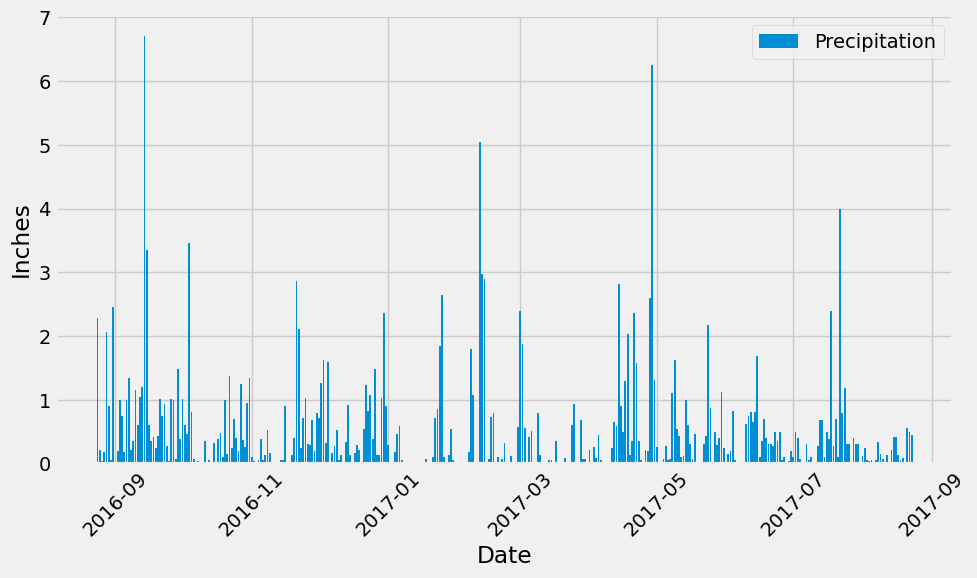

In [10]:
# Design a query to retrieve the last 12 months of precipitation data
# Starting from the most recent data point in the database.

# Find the most recent date in the dataset
date = dt_datetime(2017, 8, 23)

# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_before = dt_datetime.strptime(most_recent_date, "%Y-%m-%d") - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores directly into a DataFrame
result = session.query(
    func.max(Measurement.prcp),
    func.max(Measurement.date)
).filter(Measurement.date >= one_year_before).group_by(Measurement.date).all()


# Create a DataFrame from the result
column_names = ['Average Precipitation', 'Date']
df = pd.DataFrame(result, columns=column_names)

# Sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Average Precipitation'], width=0.8, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Average Precipitation'].agg(['count', 'mean', 'std', 'min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max'])
summary_statistics.index = ['count', 'mean', 'std', 'min', '25%', 'median', '75%', 'max']

print(summary_statistics)


count     365.000000
mean        0.517288
std         0.829196
min         0.000000
25%         0.040000
median      0.250000
75%         0.650000
max         6.700000
Name: Average Precipitation, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_numbers = session.query(func.count(Station.station)).scalar()
print(station_numbers)

9


In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_type_count = session.query(
    Measurement.station,
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in station_type_count:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = station_type_count[0][0]

temperature_data = session.query(
    Measurement.date,
    Measurement.tobs
).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_before
).all()

print(result)

[(54.0, 85.0, 71.66378066378067)]


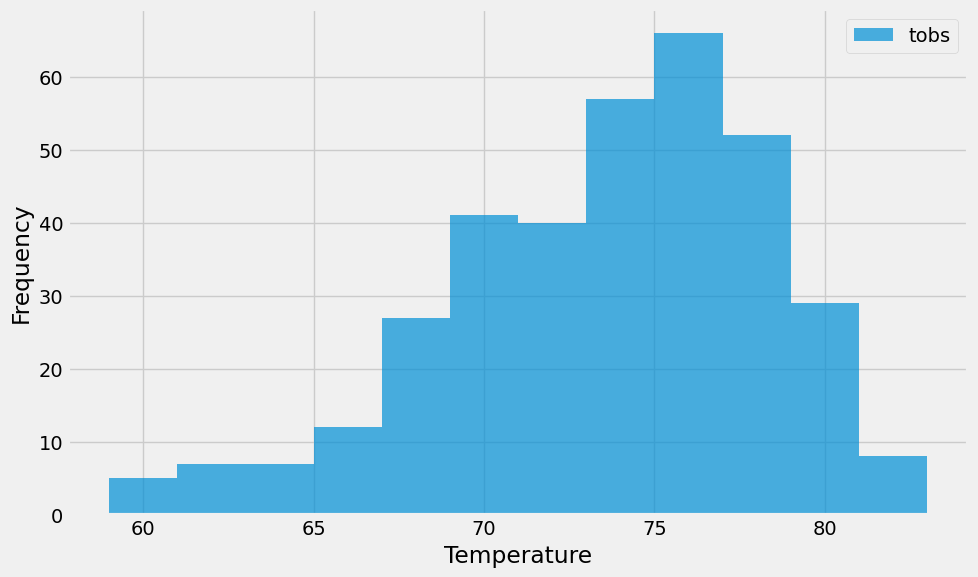

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

column_names = ['Date', 'Temperature']
df = pd.DataFrame(temperature_data, columns=column_names)

plt.figure(figsize=(10, 6))
plt.hist(df['Temperature'], bins=12, label='tobs', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [25]:
# Close Session
session.close()